In [1]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from models import RNNGC
from dataset import DatasetMaker

In [2]:
## Training parameters
train_steps = 20000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 128 # no. of recurrent units
alpha = 1/11

In [3]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng, device = device, alpha = alpha)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [4]:
dataset = DatasetMaker()

(-4.257411026954651, 6.693830037117005, -6.804481029510498, 6.7521491050720215)

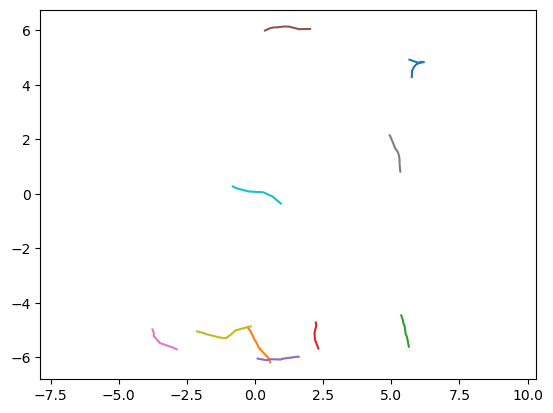

In [5]:
rt, vt = dataset.generate_data(10, 10, "cpu")

for i in range(10):
  plt.plot(rt[i,...,0], rt[i,...,1])
plt.axis(2*np.pi*np.array([-1, 1, -1, 1]))
plt.axis("equal")

In [6]:
loss_history = []
for i in tqdm(range(train_steps)):
    r, v = dataset.generate_data(bs, timesteps, device)
    loss = model.train_step(inputs = (r[:,0], v), labels = r, optimizer = optimizer)
    loss_history.append(loss.item())

100%|██████████| 20000/20000 [04:03<00:00, 82.28it/s]


Text(0, 0.5, 'Loss')

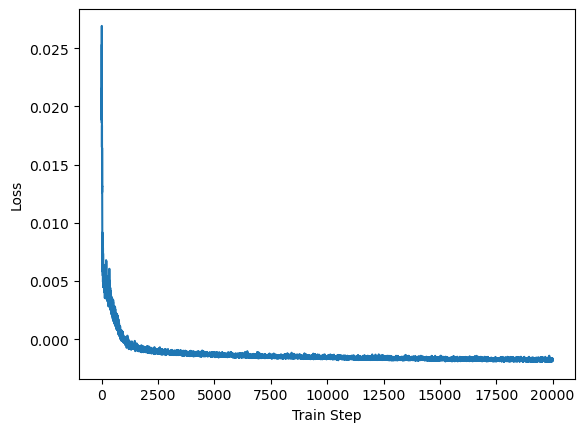

In [7]:
plt.plot(loss_history)
plt.xlabel("Train Step")
plt.ylabel("Loss")

In [8]:
r, v = dataset.generate_data(20000, 10, device)
g = model((r[:,0], v))

r = r.detach().cpu().numpy()
g = g.detach().cpu().numpy()

In [9]:
ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

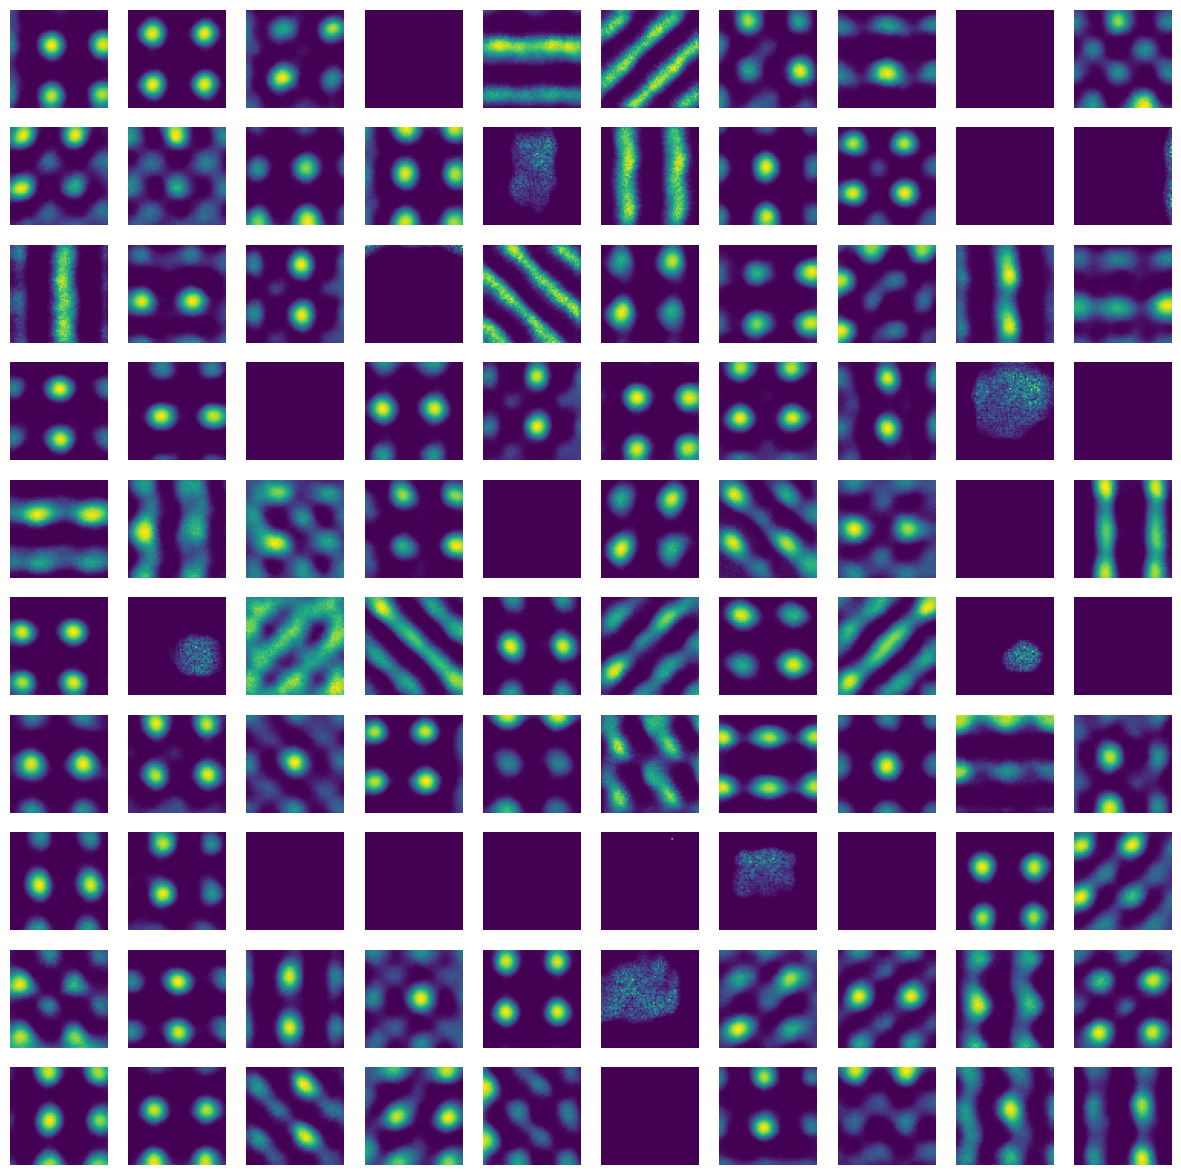

In [10]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1

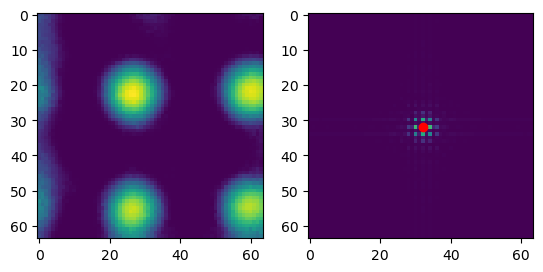

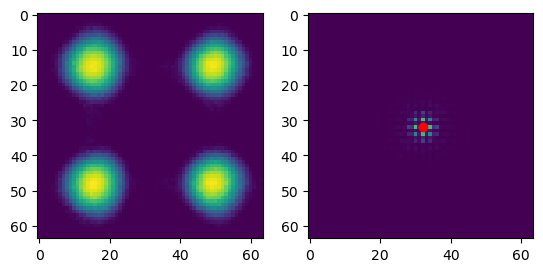

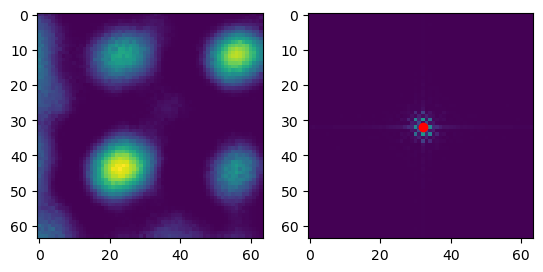

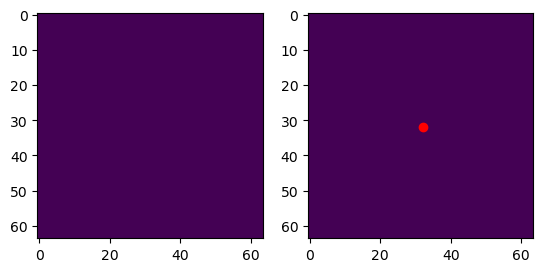

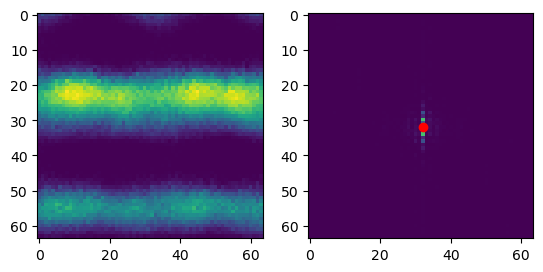

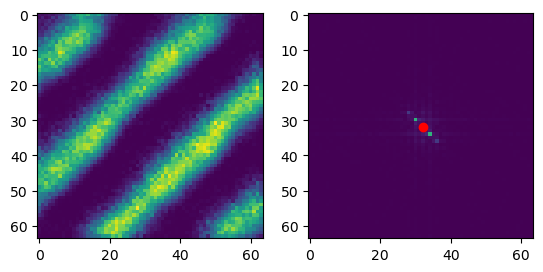

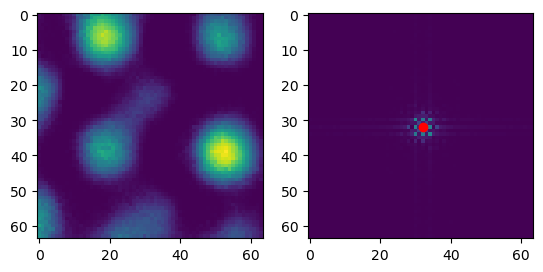

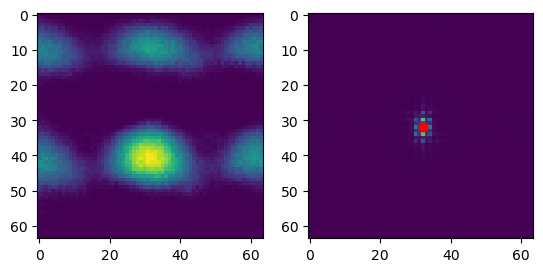

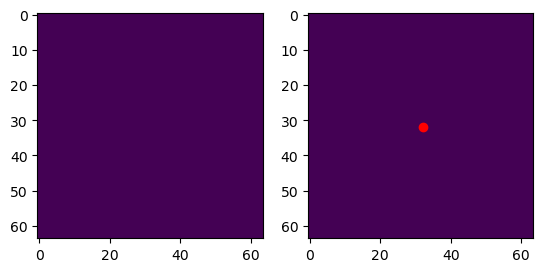

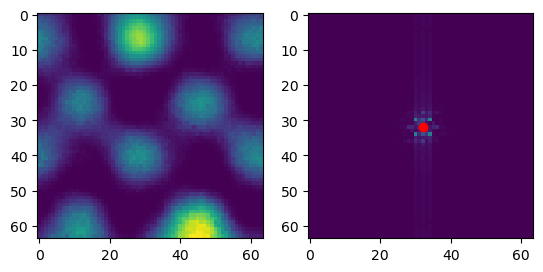

In [11]:
fft = scipy.fft.fft2(ratemaps)
fft = scipy.fft.fftshift(fft, (1, 2))
for i in range(10):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(ratemaps[i])
    ax[1].imshow(np.abs(fft[i]))
    ax[1].plot(32, 32, "ro")

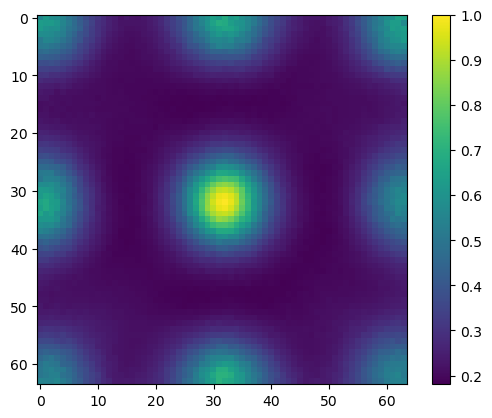

In [12]:
sim = np.exp(np.sum(-(ratemaps - ratemaps[:,32,32][:,None,None])**2, axis = 0))
plt.imshow(sim) # spatial similarity with origin
plt.colorbar()